In [1]:
%%html
<style>
.rise-enabled .cm-editor {
    font-size: 12px;
}
 
.rise-enabled .jp-OutputArea pre {
    font-size: 12px;
}

</style>

# Quantum computing and its applications (BMEVIHIAD00)
## Programming Quantum Computers 3. - Implementing algorithms in a programming language
Balázs Solymos (solymosb@hit.bme.hu)

2025 Spring

## Content

We will solve problems using `qiskit`. The calculations can be done on paper, but if anyone has a computer, feel free to follow the steps.

## Qiskit - Reminder

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import array_to_latex

# Creating a circuit
qc = QuantumCircuit(2) 
# Placing gates
qc.h(0)
qc.cx(0,1)  
# Measuring
qc.measure_all()

# Choosing a simulator and running the experiments
backend = AerSimulator()
result = backend.run(qc, shots=1000).result() # Blocking call!
# Using the results
counts = result.get_counts()
print(counts)

{'11': 486, '00': 514}


## Starting exercise

Our boss has heard that in a binary symmetric channel (BSC), the classical bits encoded by gate $H$ are insensitive to bitflips in the channel. Design an encoding and decoding box that can transmit classical data on a quantum channel without error.

<img src="bsc.png" alt="The BSC" style="margin:auto;width: 60%"/>

The matrix of the $H$ gate:

$$ H = \frac{1}{\sqrt{2}}\begin{bmatrix}
1 & 1 \\
1 & -1 
\end{bmatrix}  $$

**Solution**:

The $H$ gate can be used to solve the problem. The bit `0` is assigned |0> and `1` is assigned |1>. Apart from the global phase, encoding with $H$ protects against bitflips.

Let's look at the solution in `qiskit`:

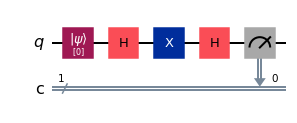

In [3]:
qc = QuantumCircuit(1,1)

# Note the initialization of the circuit
qc.initialize(0)
# Encoding
qc.h(0)

# Noise
qc.x(0)

# Decoding 
qc.h(0)
qc.measure(0,0)
qc.draw("mpl")


In [4]:
backend = AerSimulator()
result = backend.run(qc, shots=1000).result()
counts = result.get_counts()
print(counts)

{'0': 1000}


The same problem can be modeled with `qiskit`'s noisemodels. (You can find more information about the classes [on this page](https://docs.quantum.ibm.com/guides/build-noise-models)):

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit.circuit.library import HGate

p_error = 0.05

h_gate = HGate()  # regular gate
noisy_h_gate = HGate(label="Noisy H")  # first labelled gate 

bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(bit_flip, noisy_h_gate.label)
noise_model.add_basis_gates(['h'])

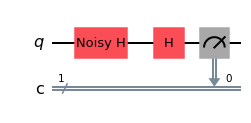

In [6]:
qc = QuantumCircuit(1, 1)

qc.append(noisy_h_gate, [0])
qc.append(h_gate, [0])

qc.measure(0,0)
qc.draw("mpl")

In [7]:
sim = AerSimulator(noise_model=noise_model)

results = sim.run(qc, shot=1024).result().get_counts()
print(results)

{'0': 988, '1': 36}


## State preparation

### Sign flip on $|0\rangle$

We would like to transform an arbitrary quantum state $\alpha|0\rangle + \beta|1\rangle$ to the following form a $-\alpha|0\rangle + \beta|1\rangle$. How can we achieve this using only the Pauli gates?

**Solution**

The necessary steps are the following:
1. First we use the $X$ gate, this takes the state to $\beta|0\rangle + \alpha|1\rangle$.
2. After this, we apply the $Z$ gate to add a minus 1 sign to the $\alpha$ amplitude.
3. The last step is to use the $X$ gate one more time to get the desired state: $-\alpha|0\rangle + \beta|1\rangle$.

Implementing these steps in `qiskit`:

In [27]:
from qiskit_aer import Aer

qc = QuantumCircuit(1) 
qc.initialize([0.6, 0.8], 0)
qc.x(0) # 1. step
qc.z(0) # 2. step
qc.x(0) # 3. step
sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([-0.6+0.j,  0.8+0.j],
            dims=(2,))


### Global phase

Starting from the $\alpha|0\rangle + \beta|1\rangle$ state, we would like to prepare the following output: $i\alpha|0\rangle + i\beta|1\rangle$. Only use the Pauli gates!

**Solution**

The desired transformation multiplies both amplitudes by $i$, so the matrix corresponding to this is $iI$. An interesting property of the Pauli gates is that multiplying any two of them (two different ones) gives the third one mutiplied by $+i$ or $-i$. For example, $YZ = +iX$. We saw earlier that Pauli gates are self-adjoint, so $+iXX = iI$, which is exactly the transformation we are looking for.

The operation to be performed is therefor $XYZ = iI$.

In `qiskit` this is:

In [9]:
qc = QuantumCircuit(1)
qc.initialize([0.6, 0.8], 0)

qc.z(0)
qc.y(0)
qc.x(0)

sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([0.+0.6j, 0.+0.8j],
            dims=(2,))


Or we can use `qiskit`'s `UnitaryGate` class to specify a given unitary transformation:

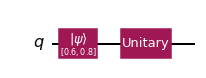

In [10]:
from qiskit.circuit.library import UnitaryGate

qc = QuantumCircuit(1)
qc.initialize([0.6, 0.8], 0)

matrix = [[1j, 0],
          [0, 1j]]

transformation = UnitaryGate(matrix)

qc.append(transformation, [0])
qc.draw("mpl")

In [11]:
sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([0.+0.6j, 0.+0.8j],
            dims=(2,))


### Adding phase to a state

Let us once again start from the $\alpha|0\rangle + \beta|1\rangle$ state. Now, we would like to prepare the $\alpha|0\rangle + \beta e^{3i\pi/4}|1\rangle$ state using the following gates:

$$
S = \begin{bmatrix}
1 & 0 \\
0 & i 
\end{bmatrix} \text{ and } S(\alpha|0\rangle + \beta|1\rangle) = \alpha|0\rangle + i\beta|1\rangle
$$

$$
T = \begin{bmatrix}
1 & 0 \\
0 & e^{i\pi/4} 
\end{bmatrix} \text{ and } T(\alpha|0\rangle + \beta|1\rangle) = \alpha|0\rangle + \beta e^{i\pi/4}|1\rangle
$$

**Solution**

We can use the fact that $e^{3i\pi/4} = e^{i\pi/4} \cdot e^{i\pi/2}$ and $e^{i\pi/2} = i$. From this the desired transformation is just the product of $T$ and $S$.

The same in `qiskit` is:

In [12]:
qc = QuantumCircuit(1)
qc.initialize(1, 0)

qc.t(0)
qc.s(0)

sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([ 0.        +0.j        , -0.70710678+0.70710678j],
            dims=(2,))


In [13]:
import math

math.e ** (3j * math.pi /4)

(-0.7071067811865475+0.7071067811865476j)

### Preparing a two-bit state

Starting from the $|00\rangle$ state, prepare the system to be in following state: $\frac{1}{2}(|00\rangle + |01\rangle + |10\rangle - |11\rangle)$. Use the $H$ and Pauli gates, but do not forget that for every gate we can have a controlled version!

**Solution**

By tensor product of two $H$ gates, we can easily bring $|00\rangle$ into the equal superposition of the basis states. But we are not done yet, since the amplitude of $|11\rangle$ still needs to be changed to $-1$. If we had only one qubit, we could easily solve the problem by using the $Z$ gate, but with two qubits it is not so easy. (Also, using the $Z \otimes Z$ transformation does not have the desired effect.)

The solution is to use the controlled $Z$ gate (or $CZ$), since it can be used to transform $|11\rangle$ into $-|11\rangle$. The complete solution in `qiskit` is:

In [14]:
qc = QuantumCircuit(2)

 
qc.h([0,1]) # do hadamard gates on qubits 0 and 1
qc.cz(0, 1)

sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j],
            dims=(2, 2))


In [ ]:
# Another possible solution is the following:
# qc.h(0)
# qc.x(0)
# qc.z(0)
# qc.x(0)
# qc.h(1)
# qc.y(1)
# qc.x(1)
# qc.z(1)
# qc.x(1)

### Preparing a composite state with different phases

Starting from $|00\rangle$ prepare the follwing state: $\frac{1}{2}(|00\rangle + i|01\rangle - |10\rangle - i|11\rangle)$. Which gates can we use to achieve this?

Hint: First try to break the output state in to the tensor product of one qubit states.

**Solution**

The output state can be broken up into the following tensor product:

$$
\frac{1}{2}\big(|00\rangle + i|01\rangle - |10\rangle - i|11\rangle\big)
= \frac{1}{2}(|00\rangle + \big(|0\rangle - |1\rangle\big) i|1\rangle - |10\rangle) =
$$
$$
= \frac{1}{2}\big(\big(|0\rangle - |1\rangle\big) |0\rangle + \big(|0\rangle - |1\rangle\big) i|1\rangle\big)
= \frac{1}{\sqrt{2}}\big(|0\rangle - |1\rangle\big) \otimes \frac{1}{\sqrt{2}}\big(|0\rangle + i|1\rangle\big)
$$

Because the output state is a composite state, we can work the two qubits separetly.

The desired state is similar to the product of two $|+\rangle = H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ state, but the phases are not right.

The first qubit is missing a $-1$, which can be fixed with the $Z$ gate. For the second qubit we need to use the previously learned $S$ gate. Putting it all together, the transformation is the follwing:

$$
 ZH|0\rangle \otimes SH|0\rangle
$$

We can easily implement this in `qiskit`:

In [15]:
qc = QuantumCircuit(2)

qc.h([0,1])
qc.z(0)
qc.s(1) 

sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([ 0.5+0.j , -0.5+0.j ,  0. +0.5j, -0. -0.5j],
            dims=(2, 2))


## Swapping states

We would like to create a unitary transform $U$ that swap the state of two qubits, that is:

$$
U(|\theta\rangle \otimes |\psi\rangle) = |\psi\rangle \otimes |\theta\rangle
$$

What is matrix of $U$? First look at the effect is has on the basis states in 4 dimension.

$U$ takes $|00\rangle$ to $|00\rangle$, $|01\rangle$ to $|10\rangle$, $|10\rangle$ to $|01\rangle$ and $|11\rangle$ to $|11\rangle$. That is:

$$
\begin{align}
U|00\rangle &= |00\rangle \\
U|01\rangle &= |10\rangle \\
U|10\rangle &= |01\rangle \\
U|11\rangle &= |11\rangle
\end{align}
$$

From this we can write up the matrix form of $U$:

$$
U = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

But how can we achieve this by simple gates?

There a number of different ways to swap the values of two variables in a programming language. One of the most well known way is the following:
```python
t = a
a = b
b = t
```

But we can achieve the same result using some bit-level trickery:
```python
a ^= b
b ^= a
a ^= b
```

Here `a ^= b` means elementwise `XOR` (mod 2 addition). Why does it work?

```python
a ^= b # After this a = a ^ b
b ^= a # After this b = b ^ (a ^ b)
a ^= b # After this a = (a ^ b) ^ (b ^ (a ^ b))
```

At the end: `b = b ^ (a ^ b) = a` and `a = (a ^ b) ^ (b ^ (a ^ b)) = b`, so the variables have indeed changed values and this transformation is reversible.

The `x_1 XOR x_2` operation for two bits can be thought of in the following way: if `x_1` is 1, we flip `x_2`.

This is the behaviour of the $CNOT$ gate. This means that $U$ can be written as:

<center><img src="swap_with_cnots.jpg"></center>

The name of $U$ is the $SWAP$ gate and because it is used in a number of different algorithms and protocols it has a special representation in a quantum circuits:

<center><img src="swap_rep.png" style="width: 10%"></center>

If your are interested in the $SWAP$ operation, you can find some interesting information [here](https://algassert.com/post/1717).

Check that the three $CNOT$ gates work in the correct way:

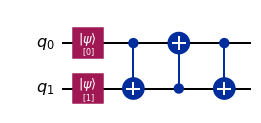

In [16]:
qc = QuantumCircuit(2)

qc.initialize(0, 0)
qc.initialize(1, 1)

# This is a ^= b
qc.cx(0, 1)
# This is b ^= a
qc.cx(1, 0)
# And the end we perform a ^= b
qc.cx(0, 1)

qc.draw("mpl")

In [17]:
sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


The same can be done in the following way:

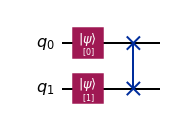

In [18]:
qc = QuantumCircuit(2)

qc.initialize(0, 0)
qc.initialize(1, 1)

qc.swap(0, 1)

qc.draw("mpl")

In [19]:
sim = Aer.get_backend("statevector_simulator")
output_state = sim.run(qc).result().get_statevector(qc)
print(output_state)

Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


### Classical control structures in qiskit

Classical control structures:

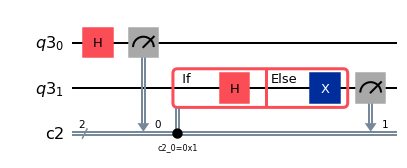

In [33]:
# Of course, qiskit has if-else as well
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1) = qubits
(c0, c1) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)) as _:
    circuit.h(q1)
with  _:
    circuit.x(q1)
circuit.measure(q1, c1)
 
circuit.draw("mpl")

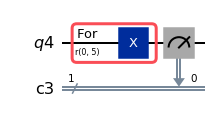

In [34]:
# We can also use a for and a while loop:
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
with circuit.for_loop(range(5)) as _:
    circuit.x(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")

## Optional bonus exercise:

Try to implement the BB84 protocol.

First: create a quantum random number generator:

In [ ]:
#random number generator here:
def qrng():
    
    return result #return 0 or 1

In [73]:
#random number generator example solution:

from qiskit import transpile

def qrng():
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure([0], [0])
    
    backend = AerSimulator()
    job_sim = backend.run(transpile(qc, backend), shots=1, memory=True)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
    result = int(list(counts)[0])
       
    return result #return 0 or 1

print(qrng())

0


#### Then create the BB84 protocol

In [74]:
#BB84 circuit here
gen_key_bits = []
for i in range(20): #lets do 20 iterations of the protocol
    qc = QuantumCircuit(1, 1)
    #Alice encode here
    
    #Bob decode here
    
#Some post processing steps

#finally print the generated key
print("Generated key:")
print(gen_key_bits)